In [1]:
from google.cloud import storage
import os
import netCDF4
import numpy as np
import numpy.ma as ma
from dask import delayed
import dask.array as da
from dask.distributed import Client
import glob
import tempfile
import subprocess
import datetime, time
from urllib import request
from multiprocessing import Pool
import json
import gc
import boto3
import botocore
import itertools

storage_client = storage.Client.from_service_account_json('/home/jovyan/work/credentials.json')
bucket = storage_client.get_bucket('nex-gddp')

loca_bucket = 'nasanex'
base_key_path = 'LOCA'
base_url = 'ftp://gdo-dcp.ucllnl.org/pub/dcp/archive/cmip5/loca/LOCA_2016-04-02/'
all_models = ["ACCESS1-0","ACCESS1-3","CCSM4","CESM1-BGC","CESM1-CAM5","CMCC-CM","CMCC-CMS","CNRM-CM5","CSIRO-Mk3-6-0","CanESM2","EC-EARTH","FGOALS-g2","GFDL-CM3","GFDL-ESM2G","GFDL-ESM2M","GISS-E2-H","GISS-E2-R","HadGEM2-AO","HadGEM2-CC","HadGEM2-ES","IPSL-CM5A-LR","IPSL-CM5A-MR","MIROC-ESM","MIROC-ESM-CHEM","MIROC5","MPI-ESM-LR","MPI-ESM-MR","MRI-CGCM3","NorESM1-M","bcc-csm1-1","bcc-csm1-1-m","inmcm4"]
some_models = ["ACCESS1-0","ACCESS1-3","CCSM4"]

client = Client('scheduler:8786')

s3 = boto3.resource('s3')


# Begin here
def process_model_year(model, scenario, year):
    process_year_temps(model, scenario, year)

def process_year_temps(model, scenario, year):
    print(f"Processing temperatures for {model} {year} ({scenario})")
    ids = (gen_netcdf_id(model, scenario, year, 'tasmax'), gen_netcdf_id(model, scenario, year, 'tasmin'))
    print(f"File ids are: {ids}")
    tasmax_file, tasmin_file = list(map(download_file, ids))
    tasmax_dataset, tasmin_dataset = netCDF4.Dataset(tasmax_file), netCDF4.Dataset(tasmin_file)
    print(tasmax_file)
    print(tasmax_dataset)
    print(tasmax_dataset['tasmax'])
    print(tasmax_dataset['tasmax'].shape)
    pass

def gen_netcdf_id(model, scenario, year, var):
    id = f'LOCA/{model}/16th/{scenario}/r1i1p1/{var}/{var}_day_{model}_{scenario}_r1i1p1_{str(year)}0101-{str(year)}1231.LOCA_2016-04-02.16th.nc'
    return id

def download_file(file_id, loca_bucket = loca_bucket, download_location = '/temp'):
    filename = f'{download_location}/{file_id.split("/")[-1]}'
    print(f"Downloading {filename}")
    try:
        s3.Bucket(loca_bucket).download_file(file_id, filename)
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            file_id = file_id.replace('r1i1p1', 'r6i1p1')
            s3.Bucket(loca_bucket).download_file(file_id, filename)
    except:
        filename = None
    return filename

def cleanup():
    for file in glob.glob('/temp/*'):
        os.remove(file)

# Actual processing
def hdd(a, axis):
    a_to_baseline = 291.483 - a
    masked = ma.masked_where(a_to_baseline <= 0, a_to_baseline)
    intermediate_matrix = ma.filled(masked, fill_value = 0)
    result = np.sum(intermediate_matrix, axis = 0)
    return result

## BASELINE

# Average of models per year
def process_baseline_year_tasmax(year, models = all_models, file_prefix = ""):
    print("Generating ids")
    ids = [gen_netcdf_id(model, 'historical', year, 'tasmax') for model in models]
    print("Downloading files")
    pool = Pool()
    filenames = pool.map(download_file, ids)
    # shape = (365, 490, 960)
    print("Stacking files")
    arr_list = list(map(lambda fn: da.from_array(netCDF4.Dataset(fn)['tasmax'], chunks = (366, 245, 240)), filenames))
    arr_stack = da.stack(arr_list)
    print("Calculating average")
    year_avg = np.mean(arr_stack, axis = 0).compute()
    result_filename = f"/temp/{file_prefix}_{year}_tasmax_baseline_average.npy"
    np.save(result_filename, year_avg)
    blob = bucket.blob(f'baseline/tasmax/intermediate/{result_filename.split("/")[-1]}')
    blob.upload_from_filename(result_filename)
    print(result_filename)
    return None

def process_baseline_year_pr(year, models = all_models, file_prefix = ""):
    print("Generating ids")
    ids = [gen_netcdf_id(model, 'historical', year, 'pr') for model in models]
    print("Downloading files")
    pool = Pool()
    filenames = pool.map(download_file, ids)
    # shape = (365, 490, 960)
    print("Stacking files")
    arr_list = list(map(lambda fn: da.from_array(netCDF4.Dataset(fn)['pr'], chunks = (366, 245, 240)), filenames))
    arr_stack = da.stack(arr_list)
    print("Calculating average")
    year_avg = np.mean(arr_stack, axis = 0).compute()
    result_filename = f"/temp/{file_prefix}_{year}_pr_baseline_average.npy"
    np.save(result_filename, year_avg)
    blob = bucket.blob(f'baseline/pr/intermediate/{result_filename.split("/")[-1]}')
    blob.upload_from_filename(result_filename)
    print(result_filename)
    return None


In [2]:
client.restart()

Client Scheduler: tcp://scheduler:8786 Dashboard: http://scheduler:8787,Cluster Workers: 1 Cores: 8 Memory: 33.68 GB


In [ ]:
for year in range(1986, 2001):
    cleanup()
    process_baseline_year_pr(year, models = all_models, file_prefix = 'baseline_v1')
process_baseline_year_pr(1985, models = all_models, file_prefix = 'baseline_v1')

In [3]:
lat_stepsize = int(490 / 5)
lon_stepsize = int(960 / 5)
lat_range = list(range(0, 490, lat_stepsize))
lon_range = list(range(0, 960, lon_stepsize))

lat_slices = [slice(i, i + lat_stepsize) for i in lat_range]
lon_slices = [slice(i, i + lon_stepsize) for i in lon_range]

all_slices = list(map(lambda tup: (slice(None), *tup), itertools.product(lat_slices, lon_slices)))
len(all_slices)

25

In [ ]:
# Baselines
def load_year_avg(year, sl, var):
    first_arr = np.load(f'/temp/baseline_v1_{str(year)}_{var}_baseline_average.npy')
    second_arr = np.array(first_arr[sl], copy=True)
    del first_arr
    if second_arr.shape[0] == 366:
        second_arr = np.delete(second_arr, 59, axis = 0)
    #print(arr.shape)
    return second_arr

In [ ]:
# Tasmax baseline
def generate_baseline_arr(all_slices, all_years, var):
    final_result = []
    for raster_slice in all_slices:
        print(f"Processing slice {raster_slice}")
        arr_list = list(map(lambda year: load_year_avg(year, raster_slice, var), all_years))
        per_day_p99 = np.percentile(np.stack(arr_list), axis = 0, q = 99)
        del arr_list
        final_result.append(np.array(per_day_p99, copy = True))
        del per_day_p99
    final_stack = np.concatenate([np.concatenate(final_result[i:i+5], axis = -1) for i in range(0, 25, 5)], axis = 1)
    final_stack[final_stack > 500] = 0
    return final_stack

# tasmax_baseline = generate_baseline_arr(all_slices, range(1971, 2001), 'tasmax')

In [ ]:
tasmax_baseline = generate_baseline_arr(all_slices, range(1971, 2001), 'tasmax')
pr_baseline = generate_baseline_arr(all_slices, range(1971, 2001), 'pr')

In [ ]:
np.save('/temp/ultimate_tasmax_baseline.npy',tasmax_baseline)
np.save('/temp/ultimate_pr_baseline.npy',pr_baseline)

In [ ]:
tasmax_baseline = np.load('/temp/ultimate_tasmax_baseline.npy')
masked_tasmax_baseline = ma.masked_where(tasmax_baseline == 0, tasmax_baseline)
masked_tasmax_baseline

In [ ]:
np.amin(masked_tasmax_baseline[masked_tasmax_baseline != 0]) - 273.15

In [12]:
%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(masked_tasmax_baseline[180, :, :] - 273.15, origin = 'lower', vmin = -15, vmax = 50)
plt.colorbar()

In [ ]:
#%matplotlib inline
from matplotlib import animation
baseline_to_animate = masked_tasmax_baseline
def animate(nframe):
    #plt.cla()
    im = plt.imshow(baseline_to_animate[nframe, :, :] - 273.15, origin = 'lower', vmin = -15, vmax = 50)
    #plt.colorbar(im)
    #plt.colorbar()
    plt.title(str(nframe))

fig = plt.figure(figsize=(10,5))
anim = animation.FuncAnimation(fig, animate, frames=365)
anim.save('output_colorbar.gif', writer='imagemagick', fps=60);
#plt.colorbar()

In [ ]:
# Tasmax baseline
def generate_avg_baseline_arr(all_slices, all_years, var):
    final_result = []
    for raster_slice in all_slices:
        print(f"Processing slice {raster_slice}")
        arr_list = list(map(lambda year: load_year_avg(year, raster_slice, var), all_years))
        per_day_avg = np.mean(np.stack(arr_list), axis = 0)
        del arr_list
        final_result.append(np.array(per_day_avg, copy = True))
        del per_day_avg
    final_stack = np.concatenate([np.concatenate(final_result[i:i+5], axis = -1) for i in range(0, 25, 5)], axis = 1)
    final_stack[final_stack > 500] = 0
    return final_stack

baseline= generate_avg_baseline_arr(all_slices, range(1971, 2001), 'tasmax')

In [ ]:
plt.figure(figsize=(8,4))
masked_baseline = ma.masked_where(baseline == 0, baseline)
plt.imshow(masked_baseline[0, :, :] - 273.15, origin = 'lower')#, vmin = 15, vmax = 50)

In [ ]:
np.save('/temp/average_baseline.npy', baseline)
#np.save('/temp/average_masked_baseline.npy', masked_baseline)

In [4]:
baseline = np.load('/temp/average_baseline.npy')

In [ ]:
download_file(gen_netcdf_id(all_models[-1], "historical", 1971, "tasmax"))

In [ ]:
ids = [gen_netcdf_id(model, 'historical', 1971, 'tasmax') for model in all_models]
print("Downloading files")
pool = Pool()
filenames = pool.map(download_file, ids)

In [9]:
filenames = sorted(glob.glob('/temp/tasmax_day*.nc'))
sorted(filenames)

['/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_ACCESS1-3_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_CCSM4_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_CESM1-BGC_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_CESM1-CAM5_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_CMCC-CMS_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_CMCC-CM_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_CNRM-CM5_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_CSIRO-Mk3-6-0_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_CanESM2_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_EC-EARTH_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc',
 '/te

<IPython.core.display.Javascript object>


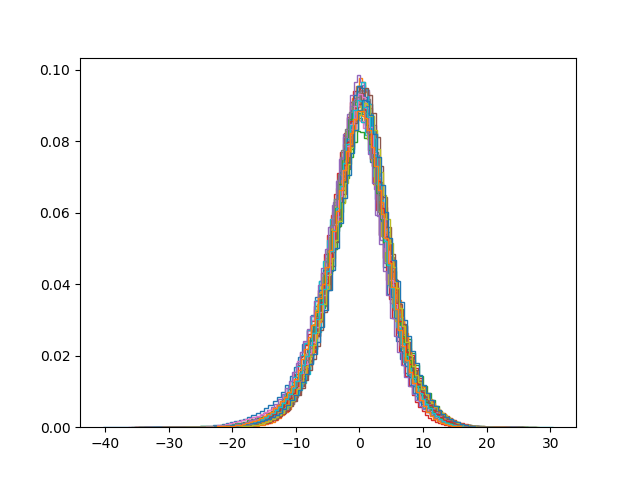

Processing /temp/tasmax_day_ACCESS1-0_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc
Processing /temp/tasmax_day_ACCESS1-3_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc
Processing /temp/tasmax_day_CCSM4_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc
Processing /temp/tasmax_day_CESM1-BGC_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc
Processing /temp/tasmax_day_CESM1-CAM5_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc
Processing /temp/tasmax_day_CMCC-CMS_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc
Processing /temp/tasmax_day_CMCC-CM_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc
Processing /temp/tasmax_day_CNRM-CM5_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc
Processing /temp/tasmax_day_CSIRO-Mk3-6-0_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc
Processing /temp/tasmax_day_CanESM2_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc
Processing /temp/tasmax_d

In [34]:
def difference_to_baseline(baseline, fname, var):
    print(f"Processing {fname}")
    arr = netCDF4.Dataset(fname)[var]
    diff = arr - baseline
    del arr
    values = diff[diff < 1000]
    plt.hist(values, density=True, bins=100, histtype='step')
    del values
    return None
plt.figure()
#hist = difference_to_baseline(baseline, filenames[0], 'tasmax')
#hist
hists = [difference_to_baseline(baseline, fname, 'tasmax') for fname in filenames]

In [ ]:
plt.figure()
plt.hist(hist, density=True, bins=100, histtype='step')

In [17]:
model_ids = [gen_netcdf_id("ACCESS1-0", 'historical', year, 'tasmax') for year in range(1971, 2001)]
print("Downloading files")
pool = Pool()
model_fnames = pool.map(download_file, model_ids)

Process ForkPoolWorker-2:
KeyboardInterrupt
Process ForkPoolWorker-7:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/envs/dask/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/dask/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/dask/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/dask/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/dask/lib/python3.6/multiprocessing/process.py", line 258, in 

In [18]:
model_fnames

['/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_19720101-19721231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_19730101-19731231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_19740101-19741231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_19750101-19751231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_19760101-19761231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_19770101-19771231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_19780101-19781231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_19790101-19791231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_19800101-19801231.LOCA_2016-04-02.16th.nc',
 '/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_19810101-19811231.LOCA_2016-04-02.16th.nc',

In [20]:
def load_arr(fname, raster_slice, var):
    arr = netCDF4.Dataset(fname)[var]
    sl = np.array(arr[raster_slice], copy=True)
    if sl.shape[0] == 366:
        sl = np.delete(sl, 59, axis = 0)
    del arr
    return sl
    
def avg_baseline_from_fnames(fnames, slices, var):
    final_result = []
    for raster_slice in all_slices:
        print(f"Processing slice {raster_slice}")
        arr_list = list(map(lambda fname: load_arr(fname, raster_slice, var), fnames))
        per_day_avg = np.mean(np.stack(arr_list), axis = 0)
        del arr_list
        final_result.append(np.array(per_day_avg, copy = True))
        del per_day_avg
    final_stack = np.concatenate([np.concatenate(final_result[i:i+5], axis = -1) for i in range(0, 25, 5)], axis = 1)
    final_stack[final_stack > 500] = 0
    return final_stack

avg_baseline_from_fnames(model_fnames, all_slices, 'tasmax')

Processing slice (slice(None, None, None), slice(0, 98, None), slice(0, 192, None))
Processing slice (slice(None, None, None), slice(0, 98, None), slice(192, 384, None))
Processing slice (slice(None, None, None), slice(0, 98, None), slice(384, 576, None))
Processing slice (slice(None, None, None), slice(0, 98, None), slice(576, 768, None))
Processing slice (slice(None, None, None), slice(0, 98, None), slice(768, 960, None))
Processing slice (slice(None, None, None), slice(98, 196, None), slice(0, 192, None))
Processing slice (slice(None, None, None), slice(98, 196, None), slice(192, 384, None))
Processing slice (slice(None, None, None), slice(98, 196, None), slice(384, 576, None))
Processing slice (slice(None, None, None), slice(98, 196, None), slice(576, 768, None))
Processing slice (slice(None, None, None), slice(98, 196, None), slice(768, 960, None))
Processing slice (slice(None, None, None), slice(196, 294, None), slice(0, 192, None))
Processing slice (slice(None, None, None), slic

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ..., 
       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 

In [27]:
def p99_baseline_from_fnames(fnames, slices, var):
    final_result = []
    for raster_slice in all_slices:
        print(f"Processing slice {raster_slice}")
        arr_list = list(map(lambda fname: load_arr(fname, raster_slice, var), fnames))
        per_day_avg = np.percentile(np.stack(arr_list), axis = 0, q = 99)
        del arr_list
        final_result.append(np.array(per_day_avg, copy = True))
        del per_day_avg
    final_stack = np.concatenate([np.concatenate(final_result[i:i+5], axis = -1) for i in range(0, 25, 5)], axis = 1)
    final_stack[final_stack > 500] = 0
    return final_stack

In [28]:
p99_baseline_from_fnames(model_fnames, all_slices, 'tasmax')

Processing slice (slice(None, None, None), slice(0, 98, None), slice(0, 192, None))
Processing slice (slice(None, None, None), slice(0, 98, None), slice(192, 384, None))
Processing slice (slice(None, None, None), slice(0, 98, None), slice(384, 576, None))
Processing slice (slice(None, None, None), slice(0, 98, None), slice(576, 768, None))
Processing slice (slice(None, None, None), slice(0, 98, None), slice(768, 960, None))
Processing slice (slice(None, None, None), slice(98, 196, None), slice(0, 192, None))
Processing slice (slice(None, None, None), slice(98, 196, None), slice(192, 384, None))
Processing slice (slice(None, None, None), slice(98, 196, None), slice(384, 576, None))
Processing slice (slice(None, None, None), slice(98, 196, None), slice(576, 768, None))
Processing slice (slice(None, None, None), slice(98, 196, None), slice(768, 960, None))
Processing slice (slice(None, None, None), slice(196, 294, None), slice(0, 192, None))
Processing slice (slice(None, None, None), slic

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ..., 
       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 

In [29]:
result_p99 = _

In [30]:
np.save('baseline_ACCESS1-0-avg.npy', result)
np.save('baseline_ACCESS1-0-p99.npy', result_p99)

In [26]:
baseline_tasavg = np.load('baseline_ACCESS1-0-avg.npy')

total 2748444
-rw-r--r-- 1 jovyan users 686784080 Jan 26 18:45 baseline_ACCESS1-0-avg.npy
-rw-rw-r-- 1 jovyan  1000   3763280 Jan 24 09:45 baseline_loca_pr.npy
-rw-rw-r-- 1 jovyan  1000   3763280 Jan 24 09:45 baseline_loca_tasmax.npy
-rw-r--r-- 1 jovyan users  13054760 Jan 25 13:18 demoanimation.gif
-rw-r--r-- 1 jovyan users  13977871 Jan 25 16:28 demoanimation_pr.gif
-rw-r--r-- 1 jovyan users 686784080 Jan 25 15:12 loca_baseline_per_day.npy
-rw-r--r-- 1 jovyan users 686784080 Jan 25 16:11 loca_baseline_per_day_pr.npy
-rw-r--r-- 1 jovyan users 686784080 Jan 25 16:11 loca_baseline_per_day_tasmax.npy
-rwxrwxr-x 1 jovyan  1000    118134 Jan 26 18:43 LOCA_dataprep.ipynb*
-rw-rw-r-- 1 jovyan  1000   5823331 Jan 23 10:11 npy_to_tiff.ipynb
-rw-r--r-- 1 jovyan users  13295136 Jan 26 13:01 output_colorbar.gif
-rw-r--r-- 1 jovyan users  13295136 Jan 26 10:30 output.gif
-rw-r--r-- 1 jovyan users     47137 Jan 26 14:26 per_model_baselines.ipynb


<IPython.core.display.Javascript object>


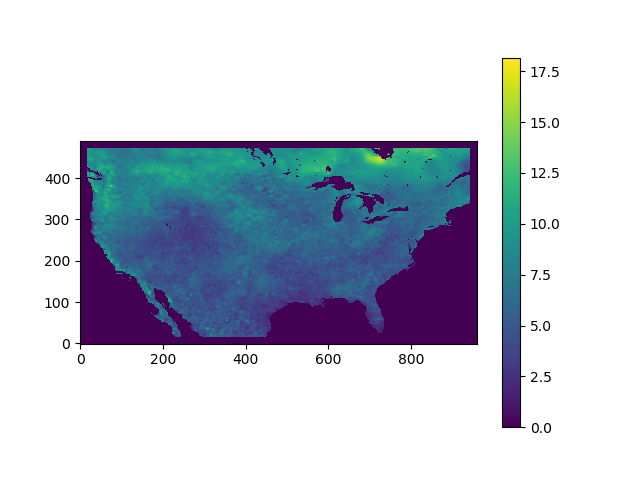

In [118]:
plt.figure()
plt.imshow((result_p99 - result)[180, :, :], origin = 'lower')
plt.colorbar()

In [66]:
download_file(gen_netcdf_id("ACCESS1-0", "rcp45", 2041, "tasmax"))
download_file(gen_netcdf_id("ACCESS1-0", "rcp45", 2081, "tasmax"))
download_file(gen_netcdf_id("ACCESS1-0", "historical", 2001, "tasmax"))

'/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_20010101-20011231.LOCA_2016-04-02.16th.nc'

In [88]:
def xh(var, baseline):
    print(var.shape)
    print(baseline.shape)
    arr_diff = var - baseline
    arr_diff[arr_diff < 0] = 0
    arr_mask = np.ma.masked_where(arr_diff > 10000, arr_diff)
    arr_mask[arr_mask > 0.0] = 1
    final_res = np.sum(arr_mask, axis = 0)
    final_res_masked = np.ma.masked_where(arr_diff[0, :, :] > 10000, final_res)
    return final_res_masked

res_1971 = xh(arr_1971, result_p99)

(365, 490, 960)
(365, 490, 960)


<IPython.core.display.Javascript object>


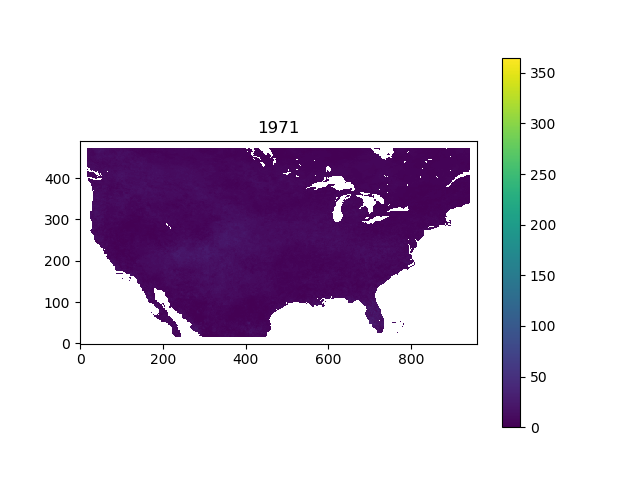

In [110]:
plt.figure()
plt.imshow(res_1971[:, :], origin = 'lower', vmin = 0, vmax = 365)
plt.title("1971")
plt.colorbar()

In [77]:
arr_1971 = netCDF4.Dataset('/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_19710101-19711231.LOCA_2016-04-02.16th.nc')['tasmax']
arr_2001 = netCDF4.Dataset('/temp/tasmax_day_ACCESS1-0_historical_r1i1p1_20010101-20011231.LOCA_2016-04-02.16th.nc')['tasmax']
arr_2041 = netCDF4.Dataset('/temp/tasmax_day_ACCESS1-0_rcp45_r1i1p1_20410101-20411231.LOCA_2016-04-02.16th.nc')['tasmax']
arr_2081 = netCDF4.Dataset('/temp/tasmax_day_ACCESS1-0_rcp45_r1i1p1_20810101-20811231.LOCA_2016-04-02.16th.nc')['tasmax']

In [91]:
res_2001 = xh(arr_2001, result_p99)
res_2041 = xh(arr_2041, result_p99)
res_2081 = xh(arr_2081, result_p99)

(365, 490, 960)
(365, 490, 960)
(365, 490, 960)
(365, 490, 960)
(365, 490, 960)
(365, 490, 960)


<IPython.core.display.Javascript object>


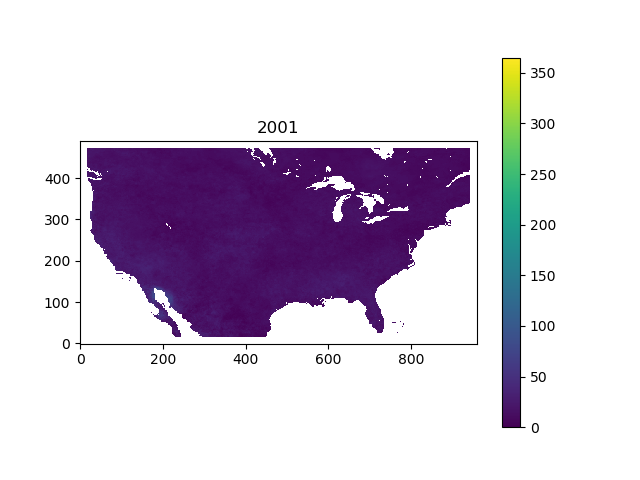

In [111]:
plt.figure()
plt.imshow(res_2001[:, :], origin = 'lower', vmin = 0, vmax = 365)
plt.title("2001")
plt.colorbar()

<IPython.core.display.Javascript object>


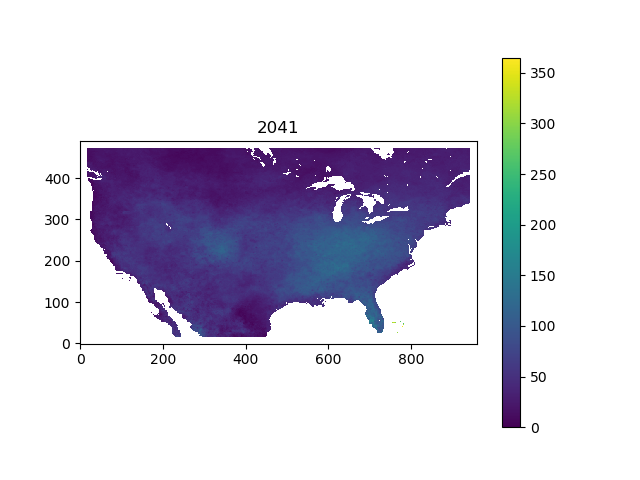

In [112]:
plt.figure()
plt.imshow(res_2041[:, :], origin = 'lower', vmin = 0, vmax = 365)
plt.title("2041")
plt.colorbar()

<IPython.core.display.Javascript object>


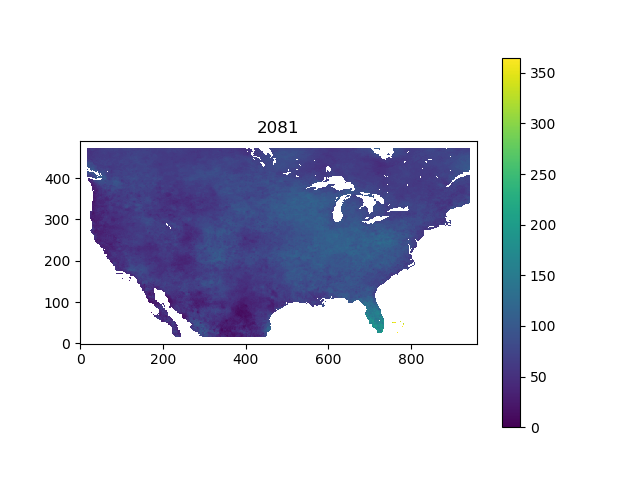

In [113]:
plt.figure()
plt.imshow(res_2081[:, :], origin = 'lower', vmin = 0, vmax = 365)
plt.title("2081")
plt.colorbar()

<IPython.core.display.Javascript object>


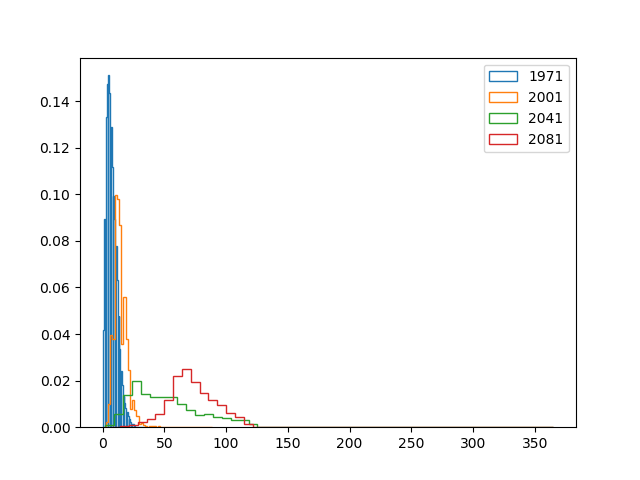

In [117]:
plt.figure()
data_2081 = res_2081.filled()
data_2081 = data_2081[data_2081 < 1000]
data_1971 = res_1971.filled()
data_1971 = data_1971[data_1971 < 1000]
data_2001 = res_2001.filled()
data_2001 = data_2001[data_2001 < 1000]
data_2041 = res_2041.filled()
data_2041 = data_2041[data_2041 < 1000]

plt.hist(data_1971, density=True, bins=50, histtype='step')
plt.hist(data_2001, density=True, bins=50, histtype='step')
plt.hist(data_2041, density=True, bins=50, histtype='step')
plt.hist(data_2081, density=True, bins=50, histtype='step')
plt.legend(["1971", "2001", "2041", "2081"])

<IPython.core.display.Javascript object>


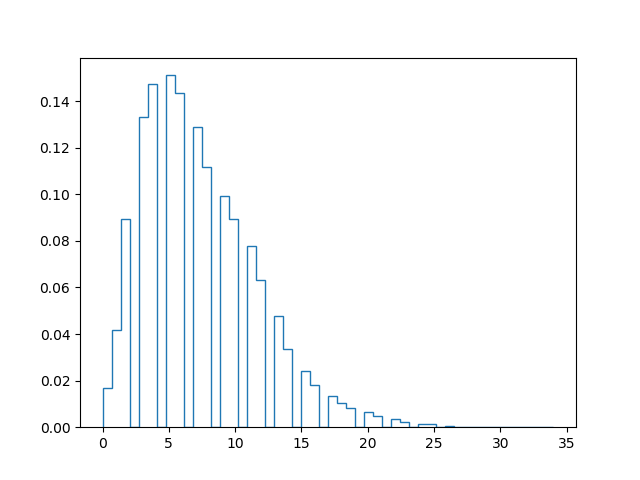

(array([  1.67472853e-02,   4.16297757e-02,   8.93786611e-02,
          0.00000000e+00,   1.33284217e-01,   1.47269404e-01,
          0.00000000e+00,   1.51093847e-01,   1.43440239e-01,
          0.00000000e+00,   1.29034835e-01,   1.11711523e-01,
          0.00000000e+00,   9.91994543e-02,   8.92747873e-02,
          0.00000000e+00,   7.78014568e-02,   6.33724453e-02,
          0.00000000e+00,   4.79235821e-02,   3.37117612e-02,
          0.00000000e+00,   2.42875770e-02,   1.80834798e-02,
          0.00000000e+00,   1.34233245e-02,   1.04912512e-02,
          8.29101579e-03,   0.00000000e+00,   6.44017399e-03,
          4.76402900e-03,   0.00000000e+00,   3.61669595e-03,
          2.43631216e-03,   0.00000000e+00,   1.39757442e-03,
          1.18038380e-03,   0.00000000e+00,   6.09078039e-04,
          2.78570576e-04,   0.00000000e+00,   2.26633689e-04,
          7.55445630e-05,   0.00000000e+00,   5.19368871e-05,
          4.24938167e-05,   0.00000000e+00,   4.72153519e-06,
        

In [116]:
plt.figure()
plt.hist(data_1971, density=True, bins = 50, histtype="step")